In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler

import pickle

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from python_files.image_reader import ImageReader
from python_files.feature_extractor import FeatureExtractor
from python_files.recognition import preprocess, apply_fov_mask
from python_files.metrics_visualizer import MetricsVisualizer
from python_files.constants import *

In [2]:
train_filename = file_names[0]
img_reader = ImageReader(IMAGES_FOLDER, MANUAL_FOLDER, MASK_FOLDER)

In [3]:
train_img = img_reader.read_img(train_filename)
train_expert_mask = img_reader.read_manual(train_filename)
train_fov_mask = img_reader.read_mask(train_filename)

In [4]:
train_img = preprocess(train_img)

In [5]:
feature_extractor = FeatureExtractor(train_img)
features = feature_extractor.extract_features()

In [6]:
# features.head()

In [7]:
Y = train_expert_mask.flatten()

In [8]:
rus = RandomUnderSampler(random_state=42)
X_undersample, Y_undersample = rus.fit_resample(features, Y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_undersample, Y_undersample, test_size=0.4, random_state=20)
model = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [10]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
prediction_test = model.predict(X_test)
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.8710671238882249


In [12]:
# importance = list(model.feature_importances_)
# feature_list = features.columns
# feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
# print(feature_imp)

In [13]:
model_name = "random_forest_model"
model_path = os.path.join(MODELS_FOLDER, model_name)
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

In [14]:
test_img_reader = ImageReader(IMAGES_FOLDER, MANUAL_FOLDER, MASK_FOLDER)

test_img = test_img_reader.read_img(file_names[1])
test_expert_mask = test_img_reader.read_manual(file_names[1])
test_fov_mask = test_img_reader.read_mask(file_names[1])

In [15]:
test_img = preprocess(test_img)
test_img_feature_extractor = FeatureExtractor(test_img)
test_features = test_img_feature_extractor.extract_features()

In [16]:
# model_filename = "random_forest_model"
loaded_model = pickle.load(open(model_path, 'rb'))
test_img_segmented = loaded_model.predict(test_features)
test_img_segmented = test_img_segmented.reshape(test_img.shape)
test_img_segmented = apply_fov_mask(test_img_segmented, test_fov_mask)

In [ ]:
test_img_reader.save_segmented(test_img_segmented, model_name)

  Accuracy    Sensitivity    Specificity      TP           TN      FP     FN
----------  -------------  -------------  ------  -----------  ------  -----
   0.90598       0.826106       0.911707  452402  6.96336e+06  674356  95230


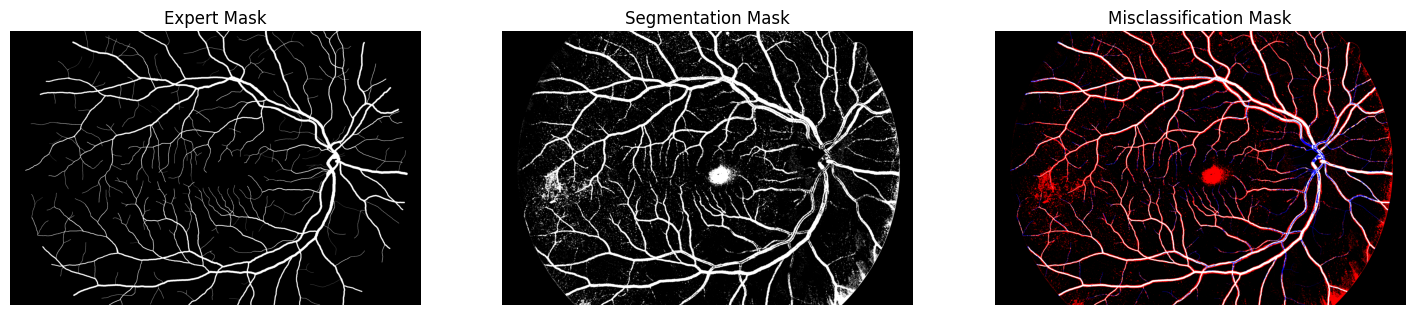

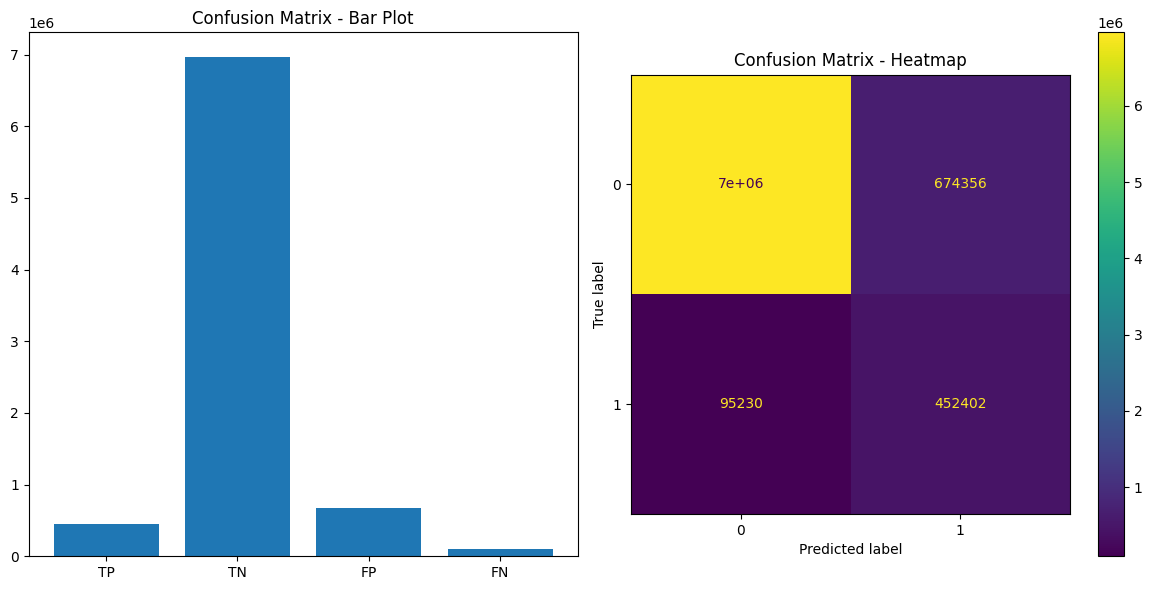

In [18]:
metrics_visualizer = MetricsVisualizer(test_expert_mask, test_img_segmented)
metrics_visualizer.calculate_metrics()
metrics_visualizer.visualize_metrics()